In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())
tf.debugging.set_log_device_placement(True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


Streaming output truncated to the last 5000 lines.
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 24/161 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0175Executing op __inference_one_step_on_iterator_20542 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_20542 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_20542 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 27/161 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0174Executing op __inference_one_step_on_iterator_20542 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_20542 in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_one_step_on_data_distributed_28129 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDat

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


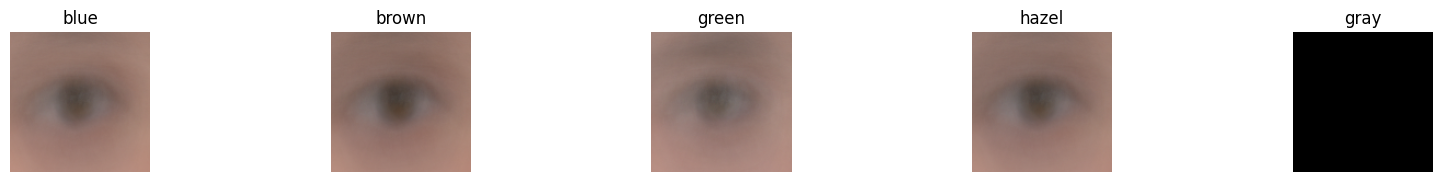

In [ ]:
# Constants
IMG_SIZE = 128
LATENT_DIM = 64
COLOR_MAPPING = {
    'blue': 0,
    'brown': 1,
    'green': 2,
    'hazel': 3,
    'gray': 4
}

def load_ubiris_data(image_folder, csv_path):
    # Read CSV file
    df = pd.read_csv(csv_path)

    # Initialize lists for images and labels
    images = []
    labels = []
    z = 0
    # Load and preprocess each image
    while z < 500:
      for idx, row in df.iterrows():
          img_path = os.path.join(image_folder, row['filename'])
          img = cv2.imread(img_path)
          z += 1
          if img is not None:
              # Resize and normalize
              img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
              img = img.astype('float32') / 255.0
              images.append(img)
              labels.append(COLOR_MAPPING[row['label']])

    return np.array(images), np.array(labels)

def get_class_averages(encoder, images, labels):
    # Get encoded vectors
    encoded_vectors = encoder.predict(images)

    # Initialize dictionary to store vectors by class
    class_vectors = {}

    # Group vectors by class
    for color, idx in COLOR_MAPPING.items():
        class_mask = labels == idx
        class_vectors[color] = np.mean(encoded_vectors[class_mask], axis=0)

    return class_vectors


# Load data
image_folder = '/content/drive/MyDrive/ML final project/datasets/CLASSES_400_300_Part1/'
csv_path = '/content/drive/MyDrive/ML final project/datasets/iris_labels_part1.csv'
x_train, y_train = load_ubiris_data(image_folder, csv_path)

# Build models (encoder, decoder, autoencoder)
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
encoded = Dense(LATENT_DIM, activation='relu')(x)

decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(256, activation='relu')(decoder_input)
x = Dense(IMG_SIZE * IMG_SIZE * 3, activation='sigmoid')(x)
decoded = Reshape((IMG_SIZE, IMG_SIZE, 3))(x)

encoder = Model(input_img, encoded)
decoder = Model(decoder_input, decoded)
autoencoder = Model(input_img, decoder(encoder(input_img)))

# Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2)


# Get class averages
class_averages = get_class_averages(encoder, x_train, y_train)

# Generate reconstructions
reconstructions = {}
for color, avg_vector in class_averages.items():
    avg_vector = avg_vector.reshape(1, LATENT_DIM)
    reconstructions[color] = decoder.predict(avg_vector)

# Visualize results
plt.figure(figsize=(20, 4))
for i, (color, img) in enumerate(reconstructions.items()):
    plt.subplot(2, len(COLOR_MAPPING), i+1)
    plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
    plt.title(color)
    plt.axis('off')
plt.show()

KeyboardInterrupt: 